In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

### Data

Load MNIST data on which we try to conduct adversial attacks

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Prep the datasets
trainset = datasets.MNIST('MnistData', download=True, train=True, transform=transform)
valset = datasets.MNIST('MnistData', download=True, train=False, transform=transform)

# Feeding for a NN
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Model

For the model we train a basic 3-layer CNN 

In [3]:
class mnistnet(nn.Module):
    
    def __init__(self, input_size, hidden1, hidden2, output_size):
        super(mnistnet, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 5)
        self.fl1 = nn.Linear(input_size, hidden1)
        self.fl2 = nn.Linear(hidden1, hidden2)
        self.fl3 = nn.Linear(hidden2, output_size)
        self.out = nn.LogSoftmax(dim=1)
        
    # Forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 4 * 4)
        x = F.relu(self.fl1(x))
        x = F.relu(self.fl2(x))
        x = self.fl3(x)
        return self.out(x)
    
my_network = mnistnet(9 * 4 * 4, 64, 32, 10)

In [4]:
optimizer = optim.SGD(my_network.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

losses = []
for epoch in range(10):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        output = my_network.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    print("\rEpoch {} loss {}".format(epoch+1,running_loss), end="")
    


Epoch 10 loss 44.38596995547414

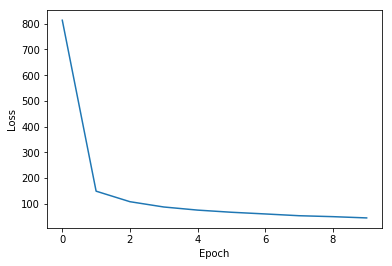

In [5]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.show()

### Adversial attack

A simple adversial attack can be done with 

$augmented\_img= img + \epsilon * sign(f(img))$

Epsilon 0


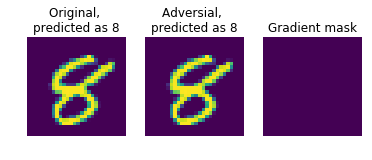

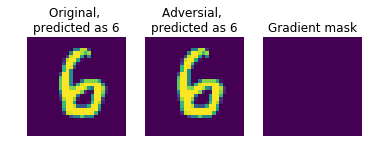

Epsilon 0.1


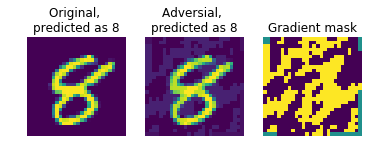

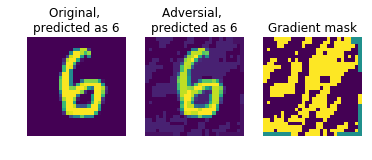

Epsilon 0.2


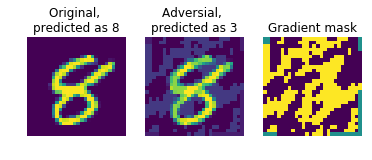

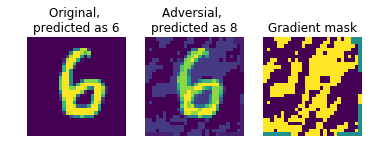

Epsilon 0.5


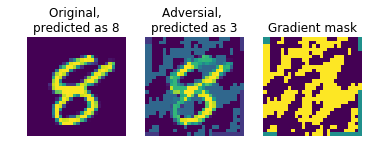

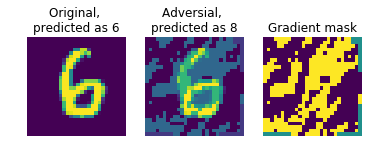

In [16]:
# Try different epsilon values to see if there is a boundary
for epsilon in [0, 0.1, 0.2, 0.5]:
    print("Epsilon {}".format(epsilon))
    for i in range(2):
        test_input = images[i]
        test_input.requires_grad = True

        # Find gradient for the test image
        output = my_network(test_input.reshape(1,1,28,28))
        my_network.zero_grad()
        loss = criterion(output, labels[i].view(1))
        loss.backward()

        # Construct attack image
        sign = test_input.grad.data.sign()
        attack_mask = epsilon * sign
        augmented_image = images[i] + attack_mask
        adversial_out = my_network(augmented_image.reshape(1,1,28,28))
        
        # Visualize results
        plt.figure()
        plt.subplot(1,3,1)
        plt.axis('off')
        plt.title("Original, \npredicted as {}".format(output.max(1)[1].item()))
        plt.imshow(images[i].reshape(28,28))
        plt.subplot(1,3,2)
        plt.axis('off')
        plt.title("Adversial, \npredicted as {}".format(adversial_out.max(1)[1].item()))
        plt.imshow(augmented_image.reshape(28,28))
        plt.subplot(1,3,3)
        plt.axis('off')
        plt.title("Gradient mask")
        plt.imshow(attack_mask.reshape(28,28))
        plt.show()